# Example of use with a series of NetCDF files

In [1]:
from typing import Dict, List, Tuple
import concurrent.futures as cf
import collections
import traceback
import pickle
import os
import sys
import netCDF4
import numcodecs
import numpy as np
import time
import shutil
import dask.distributed

In [ ]:
import geohash.index
import geohash.storage
import geohash.core
import geohash.lock

Creation of a local dask cluster, which will be used to process the series of files faster.

In [ ]:
cluster = dask.distributed.LocalCluster(processes=True)
client = dask.distributed.Client(cluster)
client

In [5]:
def get_files(dirname: str) -> List[str]:
    """Returns the list of file to be processed"""
    result = []
    for root, dirs, files in os.walk(dirname):
        result += [os.path.join(root, item) for item in files if item.endswith(".nc")]
    return result

In [6]:
def read_positions_satellite(path: str) -> np.ndarray:
    """Read the positions of the satellite from a netCDF dataset"""
    dtype = np.dtype([("lng", "f8"), ("lat", "f8")])
    with netCDF4.Dataset(path) as ds:
        lng = ds.variables['longitude'][:]
        lat = ds.variables['latitude'][:]
        points = np.empty((len(ds.dimensions['time']), ), dtype=dtype)
        points["lng"][:] = ds.variables['longitude'][:]
        points["lat"][:] = ds.variables['latitude'][:]
        
        return points

In [7]:
def get_geohash_from_file(paths: List[str], precision: int
    ) -> Dict[bytes, Tuple[str, Tuple[int, int]]]:
    """Creation of an associative dictionary between GeoHash codes and the
    file name start and last indexes of the data selected for that code."""
    hashs = collections.defaultdict(list, {})
    for path in paths:
        points = read_positions_satellite(path)
        # Calculate geohash codes for each position read
        idents = geohash.string.encode(points, precision)
        # Calculate indices when the geohash codes are different
        indexes = np.where(idents[:-1] != idents[1:])[0] + 1
        # Create a tuple that contains the first/last index for each box
        data = zip(np.insert(indexes, 0, 0), indexes)
        # Finally create a map between geohash code and first/last index
        for code, coordinates in zip(idents[np.insert(indexes, 0, 0)][0:-1], data):
            hashs[code].append((path, coordinates))
    return hashs

In [8]:
files = get_files("/home/fbriol/Data/dt-along-track/tp")

The database is destroyed if it exists.

In [9]:
UNQLITE = "/tmp/test.unqlite"
if os.path.exists(UNQLITE):
    os.unlink(UNQLITE)

We don't synchronize the writings because only one thread will write in the database

In [10]:
index = geohash.index.init_geohash(
    geohash.storage.UnQlite(UNQLITE, mode="w"),
    precision=3,
    synchronizer=None)

The reading of the data will be divided over 12 workers

In [11]:
files = np.array_split(files, 12)

We calculate the properties of the files to be processed

In [12]:
futures = [client.submit(get_geohash_from_file, item, index.precision) for item in files]

Populate the database with the constructed data. The data is compressed during writing in order to optimize the I/O. This compression takes a little time, but it allows to keep the base in RAM (about 350 MB vs 3 GB).

In [13]:
data = collections.defaultdict(list)
for item in dask.distributed.as_completed(futures):
    for k, v in item.result().items():
        data[k] += v

In [18]:
%%time
index.update(data)

CPU times: user 1min 22s, sys: 1.38 s, total: 1min 24s
Wall time: 1min 22s


Flush data on the disk

In [19]:
del futures, data
index.store.commit()

Query for one box

In [22]:
%timeit len(index.box(geohash.string.bounding_box("cet")))

15.4 ms ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Query for one area

In [21]:
%%timeit
len(index.box(
    geohash.Box(geohash.Point(-135, 0),
                geohash.Point(-90, 45))))

1.36 s ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Calculate statistics on data selected

Example of use, calculating the average SLA of each track passing through the selected geographical box. 

In [23]:
index = geohash.index.open_geohash(
    geohash.storage.UnQlite(UNQLITE, mode="rm"),
    synchronizer=None)

In [47]:
x = list()
y = list()
for file, coords in index.box(geohash.core.string.bounding_box("cet")):
    with netCDF4.Dataset(file) as ds:
        sla = ds.variables['sla_unfiltered']
        time = ds.variables['time']
        for item in coords:
            x.append(netCDF4.num2date(time[slice(*coords)].mean(), time.units))
            y.append(sla[slice(*coords)].mean())

In [51]:
ix = np.argsort(x)
x = np.array(x).astype("datetime64[s]")[ix]
y = np.array(y)[ix]

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

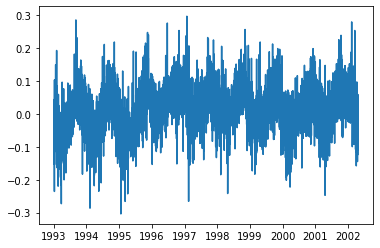

In [53]:
plt.plot(x, y)

In [54]:
del index
client.close()
cluster.close()